# Chapter 2: Taking Earth's Temperature

### PART II: Comparing Re-analysis with Observations since 1950 <a class="anchor" id="chapter-one"></a>

This tutorial is Part II of the trilogy “Taking Earth’s Temperature”:

1. **Long-Term Development** of Global Earth Temperature Since 1850
2. **Comparing Re-analysis with Observations since 1950**  ([this notebook](#part-two))
3. **Visualising Recent Temperature Anomalies**

In the first part of this scientific journey, we unlocked the secrets of surface temperatures since 1850. We explored various datasets, learning how to decode them, and laid the groundwork for what comes next.

<div class="alert alert-block alert-success">
<b>Objective</b> <br>
    In this second act, we'll delve into a side-by-side analysis of <b>ERA5 re-analysis</b> and modern observational data in Europe. Imagine this as zooming into a detailed map from a bird's eye view, starting with annual anomalies, then diving into seasonal, monthly, and even daily variations. It's like piecing together a puzzle to reveal the full picture of the European climate.
 </a>
</div>

Our journey will be guided by two datasets:

1. [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview): A global data set that provides hourly estimates of a large number of atmospheric, land and oceanic parameters, including temperature and humidity.
2. [E-OBS](https://www.ecad.eu/download/ensembles/download.php): A dataset that provides a daily gridded observational dataset for precipitation, temperature, and sea level pressure in Europe.

*Note that we use the monthly averaged data for ERA5.*

| Dataset | Spatial Coverage | Spatial Resolution | Temporal Coverage | Temporal resolution |Provider |
|---------|:-------------:|:------:|:------:|:------:|:------:|
|  E-OBS |  Europe | 0.10º x 0.10º | 1950 - today | Daily | ECA&D |
|  ERA5 |  Global | 0.25º x 0.25º | 1940 - today | Monthly | C3S/ECMWF |

Get ready to put on your data scientist's hat as we build on methods from the first part to form spatial and temporal averages. Along the way, we'll create vivid visualizations, bringing data to life and making sense of what it tells us. By the end of this chapter, we'll be able to compute daily anomalies within a year, forming a crucial piece of this year's European State of the Climate report ([ESOTC 2022](https://climate.copernicus.eu/esotc/2022/temperature)).

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=vis-animations.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

-----------------------

#### Getting Set Up

We begin by importing all necessary packages:

In [1]:
# Python Standard Libraries
import os
import calendar
import tarfile

# Data Manipulation Libraries
import numpy as np
import pandas as pd
import xarray as xr
import dask

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.diagnostics.progress import ProgressBar

# Climate Data Store API for retrieving climate data
import cdsapi

The following cell ensures a consistent figure layout. If this notebook is run on one of the cloud platforms, the stylesheet will not be present by default. Either load the file into the Cloud Server additionally, or ignore the following cell. It will have no effect on the calculation.

In [2]:
plt.style.use("../copernicus.mplstyle")

Additionally, we instruct dask to avoid creating large chunks, which can occur during various calculations.

In [3]:
dask.config.set(**{"array.slicing.split_large_chunks": True})

In the following cells, we define global parameters that we will continually refer to. Depending on interest, these can be adjusted as desired. Firstly, we define the `REGIONS` we are interested in, in our case, Europe. Note we followed the definition used in the [C3S Climate Intelligence reports](https://climate.copernicus.eu/esotc/2022/about-data#Regiondefinitions), however, feel free to change it!

In [4]:
REGIONS = {"Europe": {"lon": slice(-25, 40), "lat": slice(34, 72)}}

We also define the necessary projections, which we need for visualising spatial data. The data each lie on a regular longitude-latitude grid, so we choose `PlateCarree`. For Europe, we select the `TransverseMercator` projection, a method that provides less distortion in mapping the region, due to its alignment with meridians (more on projections and using `cartopy` in Part III).

In [5]:
PROJS = {
    "Europe": ccrs.TransverseMercator(central_longitude=15, central_latitude=52),
    "Data": ccrs.PlateCarree(),
}

Here, we choose the reference period for calculating the climatology. We use the currently updated period from 1991-2020.

In [6]:
REF_PERIOD = {"time": slice("1991", "2020")}

Since we tap into two different data sources, both coming in their unique formats and peculiarities, let's organise the data into folders for a better overview. If these do not exist, they will be created.

In [7]:
file_name = {}  # dictionary containing [data source : file name]

file_name.update({"era5": "temperature_era5.nc"})
file_name.update({"eobs": "temperature_eobs.tar.gz"})

# Create the paths to the files
path_to = {
    source: os.path.join(f"data/{source}/", file) for source, file in file_name.items()
}

# Create necessary directories if they do not exist
for path in path_to.values():
    os.makedirs(
        os.path.dirname(path), exist_ok=True
    )  # create the folder if not available

path_to

{'era5': 'data/era5/temperature_era5.nc',
 'eobs': 'data/eobs/temperature_eobs.tar.gz'}

As we will see, the different data come with varying conventions regarding dimension names and coordinates. We'll make our work much easier if we ensure from the outset that all data are in the same format. This means, in our case, we want to streamline datasets in the following way:
- Dimension names are (`time`, `lon`, `lat`)
- (Only for monthly resolved `time` coordinate): `time` coordinate is in `datetime` format and fixed at the beginning of the month
- The `lon` and `lat` coordinates are sorted by size
- The `lon` coordinate is defined from -180 to +180 º (as opposed to 0 to 360º)

In [8]:
def coordinate_is_monthly(ds, coord: str = "time"):
    """Return True if the coordinates are months"""
    time_diffs = np.diff(ds.coords[coord].values)
    time_diffs = pd.to_timedelta(time_diffs).days

    # If all differences are between 28 and 31 days
    if np.all((28 <= time_diffs) & (time_diffs <= 31)):
        return True
    else:
        return False

In [9]:
def streamline_coords(da):
    """Streamline the coordinates of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to streamline.
    """

    # Ensure that time coordinate is fixed to the first day of the month
    if "time" in da.coords:
        if coordinate_is_monthly(da, "time"):
            da.coords["time"] = da["time"].to_index().to_period("M").to_timestamp()

    # Ensure that spatial coordinates are called 'lon' and 'lat'
    if "longitude" in da.coords:
        da = da.rename({"longitude": "lon"})
    if "latitude" in da.coords:
        da = da.rename({"latitude": "lat"})

    # Ensure that lon/lat are sorted in ascending order
    da = da.sortby("lat")
    da = da.sortby("lon")

    # Ensure that lon is in the range [-180, 180]
    lon_min = da["lon"].min()
    lon_max = da["lon"].max()
    if lon_min < -180 or lon_max > 180:
        da.coords["lon"] = (da.coords["lon"] + 180) % 360 - 180
        da = da.sortby(da.lon)

    return da

#### Downloading the Data

We are now ready to download the various data.

##### ERA5

Now, we load ERA5 from the [Climate Data Store (CDS)](https://doi.org/10.24381/cds.f17050d7) using the `cdsapi`, including the land-sea mask. To access the CDS programatically, we'll have to provide our CDS API key.

In [12]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'

<div class="alert alert-block alert-info">
<b>New to CDS?</b> Consider the <a href="https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html">CDS tutorial</a> for a detailed guide.
</div>

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'land_sea_mask'],
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
  },
  path_to['era5']
)

After opening and streamlining the ERA5 data, we will perform the following operations:
1. Focusing on Europe
2. Converting temperatures from Kelvin to Celsius
3. Calculating the monthly climatology

In [10]:
with xr.open_mfdataset(path_to["era5"]) as era5:
    pass

# Streamline coordinates
era5 = streamline_coords(era5)

# Focus on Europe
era5 = era5.sel(REGIONS["Europe"])

# Convert temperature from Kelvin to Celsius
era5["t2m"] = era5["t2m"] - 273.15

# Compute monthly climatology
era5_monthly_climatology = era5["t2m"].sel(REF_PERIOD).groupby("time.month").mean()
era5["anom"] = era5["t2m"].groupby("time.month") - era5_monthly_climatology

# Europe only
with ProgressBar():
    era5 = era5.compute()

era5

/home/nikos_mastrantonas/anaconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 73 times more chunks
  return self.array[key]


[########################################] | 100% Completed | 77.62 s


<xarray.Dataset>
Dimensions:  (lon: 261, lat: 153, time: 876)
Coordinates:
  * lon      (lon) float32 -25.0 -24.75 -24.5 -24.25 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float32 34.0 34.25 34.5 34.75 35.0 ... 71.25 71.5 71.75 72.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m      (time, lat, lon) float32 16.74 16.72 16.68 ... 0.116 0.1178 0.1051
    lsm      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    anom     (time, lat, lon) float32 -0.7348 -0.7398 -0.7562 ... 1.13 1.138
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-13 06:04:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

##### E-OBS

E-OBS can be downloaded either at high resolution (0.10º) or low resolution (0.25º). Here, we use the lower resolution, as it matches that of ERA5, making the comparison more direct.

<div class="alert alert-block alert-warning">
<b>NOTE</b> <br>
    If you use this data for the first time, you might have to go to the CDS website and accept the terms for being able to download and use the data
 </a>
</div>

In [14]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'format': 'tgz',
        'product_type': 'ensemble_mean',
        'variable': 'mean_temperature',
        'grid_resolution': '0.25deg',
        'period': 'full_period',
        'version': '27.0e',
    },
    path_to['eobs']
)

2023-08-14 13:15:56,735 INFO Welcome to the CDS
2023-08-14 13:15:56,736 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-europe
2023-08-14 13:15:57,458 INFO Request is queued
2023-08-14 13:15:59,155 INFO Request is running
2023-08-14 13:18:57,283 INFO Request is completed
2023-08-14 13:18:57,284 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data7/dataset-insitu-gridded-observations-europe-83d5d9b6-b8d4-4098-bd9c-ae946016ed9f.tar.gz to data/eobs/temperature_eobs.tar.gz (752.3M)
2023-08-14 13:38:53,092 INFO Download rate 644.2K/s   


Result(content_length=788796139,content_type=application/gzip,location=https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data7/dataset-insitu-gridded-observations-europe-83d5d9b6-b8d4-4098-bd9c-ae946016ed9f.tar.gz)

The data is downloaded as a compressed `.tgz` file. We use the `tarfile` library to unpack the compressed file and save it.

In [14]:
# open file
file = tarfile.open(path_to['eobs'])
  
# print file names
print(file.getnames())
  
# extract files
file.extractall('data/eobs')

['tg_ens_mean_0.25deg_reg_v27.0e.nc']


After unpacking, we get a single NetCDF file (`tg_ens_mean_0.25deg_reg_v27.0e.nc`), which we can open with `xarray` and then streamline.

In [15]:
eobs_daily = xr.open_mfdataset("data/eobs/tg_ens_mean_0.25deg_reg_v27.0e.nc")
eobs_daily = streamline_coords(eobs_daily)

Similar to ERA5, we first focus on our defined central European region. Since E-OBS comes in daily resolution, we initially compute a second, monthly resolved version. We take a conservative approach and set the monthly average to `NaN` if there is at least one missing value within the month (`skipna=False`).

In [16]:
# Figure 1. Annual European land surface air temperature anomalies for
# 1950 to 2022, relative to the 1991–2020 reference period.
# =============================================================================

# Select the region of interest
eobs_daily = eobs_daily.sel(REGIONS["Europe"])

# Convert EOBS to monthly
eobs = eobs_daily.resample(time="MS", skipna=False).mean("time")

# Let's compute and load the data into memory which makes further processing faster
with ProgressBar():
    eobs = eobs.compute()

# Calculate the monthly climatology
eobs_monthly_climatology = (
    eobs["tg"].sel(REF_PERIOD).groupby("time.month").mean()
)
eobs["anom"] = eobs["tg"].groupby("time.month") - eobs_monthly_climatology
eobs["climatology"] = eobs_monthly_climatology

[########################################] | 100% Completed | 29.56 s


#### Annual Anomalies


Our first goal will be to calculate annual anomalies based on ERA5 and E-OBS. Basically, two steps are necessary for this:

1. Calculation of a **spatial mean of the anomalies** in Europe per time step, taking into account the land-sea mask.
2. Calculation of the **annual anomaly** based on the monthly anomalies, weighting the individual months based on the number of days.

We summarize these two steps into two functions and finally define a function that carries out both steps in one go.

In [17]:
def weighted_spatial_average(da, land_mask=None):
    """Calculate the weighted spatial average of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to average.
    weights : xr.DataArray, optional
        A DataArray with the same dimensions as `da` containing the weights.
    """
    # Area weighting: calculate the area of each grid cell
    weights = np.cos(np.deg2rad(da.lat))

    # Additional user-specified weights, e.g. land-sea mask
    if land_mask is not None:
        weights = weights * land_mask.fillna(0)

    return da.weighted(weights).mean(("lat", "lon"))

In [18]:
def weighted_annual_average(da):
    """Calculate the weighted annual average per year."""
    days_in_month = da.time.dt.days_in_month
    weights = (
        days_in_month.groupby("time.year") / days_in_month.groupby("time.year").sum()
    )
    sum_weights = weights.groupby('time.year').sum()
    np.testing.assert_allclose(sum_weights, 1)
    return (da * weights).groupby('time.year').sum(skipna=False)

In [19]:
# Calculate the monthly climatology
def annual_anomalies(da, land_mask=None):
    # 1. Calculate the spatial average
    da = weighted_spatial_average(da, land_mask)
    # 2. Calculate the weighted (per days in month) annual average
    return weighted_annual_average(da)

Let's use the domain of interest.

Now, calculating the annual anomalies is a one-liner! We give each dataset an appropriate name and then proceed directly to visualization.

In [20]:
eobs_europe_anom = annual_anomalies(eobs["anom"], land_mask=None)
era5_europe_anom = annual_anomalies(era5["anom"], land_mask=era5["lsm"])

eobs_europe_anom.name = "EOBS"
era5_europe_anom.name = "ERA5"

The following visualization of the annual temperature anomalies is modeled after the corresponding representation in this year's [ESOTC 2022](https://climate.copernicus.eu/esotc/2022/temperature).

In [21]:
def barplot_temperature(da1, da2, title=""):
    # make red and blue colors for above and below zero
    clrs = sns.color_palette("Paired", n_colors=6)
    clrs_da1 = [clrs[0] if anom < 0 else clrs[4] for anom in da1.values]
    clrs_da2 = [clrs[1] if anom < 0 else clrs[5] for anom in da2.values]

    fig = plt.figure(figsize=(14, 5))
    ax = fig.add_subplot(111)
    ax.bar(
        da1.year,
        da1,
        color=clrs_da1,
        label=da1.name,
        zorder=1,
    )
    ax.bar(
        da2.year,
        da2,
        0.25,
        color=clrs_da2,
        label="ERA5",
        zorder=2,
    )
    # Add an annotation for both datasets pointing to the last bar at the right hand side
    # with text "ERA5" and "EOBS" respectively. The text should be in the same color as
    # the bar.
    da1_final_data = (da1[-1].year.item(), da1[-1].item())
    da2_final_data = (da2[-1].year.item(), da2[-1].item())
    ax.annotate(
        da1.name,
        xy=da1_final_data,
        xytext=(2023, 1.4),
        arrowprops=dict(arrowstyle="-|>", color=clrs[4]),
        color=clrs[4],
        ha="left",
        xycoords="data",
    )
    ax.annotate(
        da2.name,
        xy=da2_final_data,
        xytext=(2023, 0.3),
        color=clrs[5],
        arrowprops=dict(arrowstyle="-|>", color=clrs[5]),
        ha="left",
        xycoords="data",
    )
    ax.axhline(0, color=".5", lw=0.5, ls="--")
    ax.set_title(title)
    sns.despine(ax=ax, offset=5, trim=True)
    plt.show()

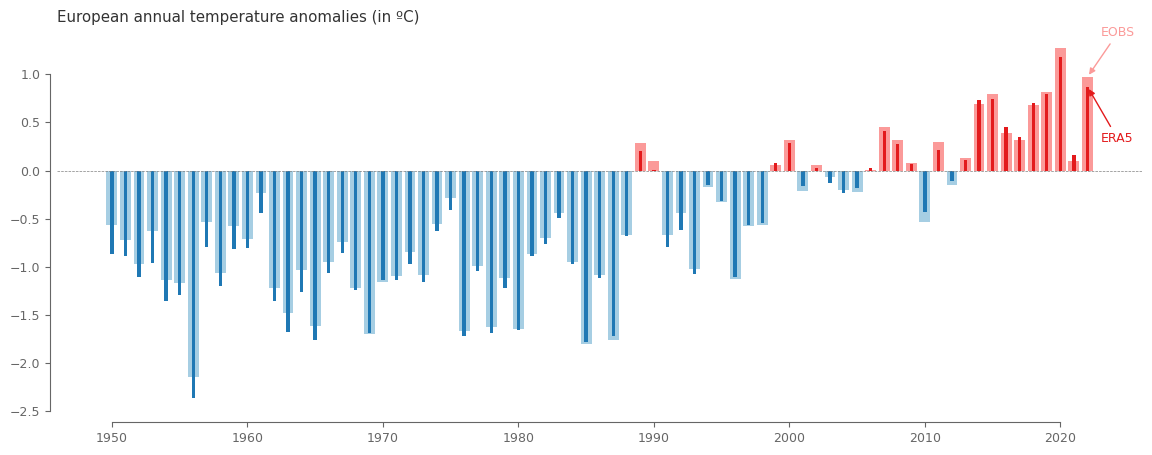

In [22]:
title = "European annual temperature anomalies (in ºC)"
barplot_temperature(eobs_europe_anom, era5_europe_anom, title)

Overall, we see that both datasets essentially agree, and the annual anomalies of the last ~70 years show a high degree of consistency. Let's take a closer look by calculating the difference between ERA5 and E-OBS and plotting it in a bar plot:

In [23]:
diff = era5_europe_anom - eobs_europe_anom

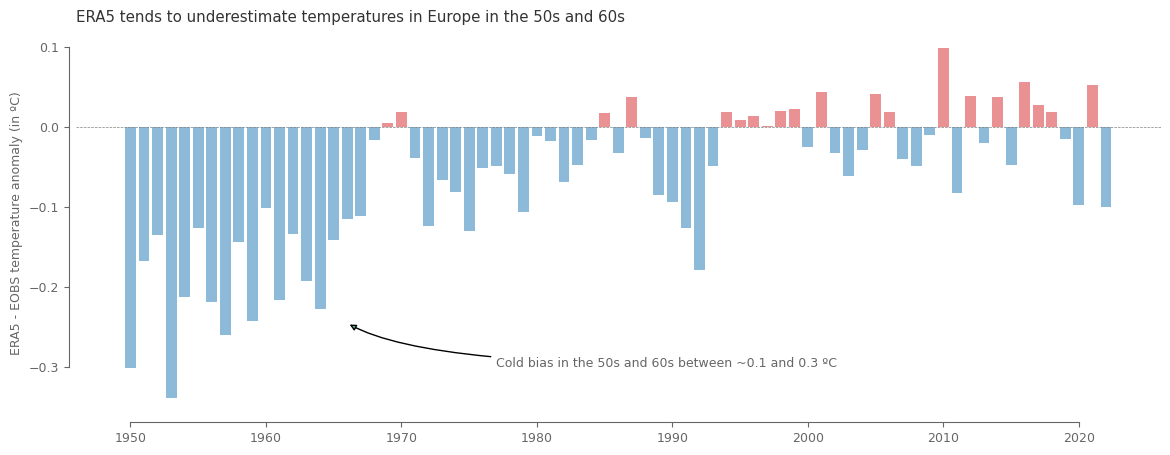

In [24]:
clrs_diff = np.where(diff > 0, "tab:red", "tab:blue")

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)
ax.bar(
    diff.year,
    diff,
    color=clrs_diff,
    label="",
    alpha=0.5,
)
ax.axhline(0, color=".5", lw=0.5, ls="--")
ax.set_title("ERA5 tends to underestimate temperatures in Europe in the 50s and 60s")
ax.annotate(
    "Cold bias in the 50s and 60s between ~0.1 and 0.3 ºC",
    xy=(1966, -0.245),
    xytext=(1977, -0.3),
    # make a curved arrow
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="angle3,angleA=0,angleB=-30",
    ),
    ha="left",
    xycoords="data",
)
ax.set_ylabel("ERA5 - EOBS temperature anomaly (in ºC)")
sns.despine(ax=ax, offset=5, trim=True)


It becomes clear from this that the discrepancy between reanalysis and observation has been very small since the mid-90s, with deviations usually significantly below 0.1 ºC. However, it is also evident that the differences can be much higher at the beginning of the reanalysis, with deviations up to ~0.3ºC. Moreover, we find that these are not statistical but systematic deviations, as ERA5 tends to show colder temperatures in the 50s and partly 60s compared to observation data.

Next, we'll examine the spatial differences in the annual anomalies for 2022. To do this, we calculate the mean annual anomalies using our already defined function, without first calculating the spatial average.

In [25]:
# Figure 2. Average surface air temperature anomaly for 2022,
# relative to the 1991–2020 reference period.
# =============================================================================

eobs_yearly_anoms = weighted_annual_average(eobs["anom"])
era5_yearly_anoms = weighted_annual_average(era5["anom"])


Next, we present the spatially resolved annual anomalies. We will also define a function for this plot that we can reuse later. To better understand the anomalies, we visualize basic quantities of the underlying statistical distribution of both datasets in the form of a boxplot, which we apply to the color bar.

In [26]:
levels = np.arange(-3, 3.5, 0.5)
kwargs = dict(
    levels=levels,
    transform=PROJS["Data"],
    cmap="RdYlBu_r",
    cbar_kwargs=dict(label="Temperature anomaly (ºC)"),
)

def spatial_plot_temperature(da1, da2, year):
    proj = ccrs.Orthographic(central_longitude=10, central_latitude=45)
    fig = plt.figure(figsize=(14, 5))
    gs = GridSpec(1, 4, figure=fig, width_ratios=[0.05, 1, 1, 0.05], wspace=0.02)
    ax1 = fig.add_subplot(gs[0, 1], projection=PROJS["Europe"])
    ax2 = fig.add_subplot(gs[0, 2], projection=PROJS["Europe"])
    cax1 = fig.add_subplot(gs[0, 0])
    cax2 = fig.add_subplot(gs[0, 3])
    for ax in [ax1, ax2]:
        ax.coastlines("50m", lw=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor=".6")
        ax.add_feature(cfeature.LAND, facecolor=".8")
        ax.set_extent([-25, 40, 34, 72], crs=PROJS["Data"])

    da1.sel(year=year).plot(ax=ax1, cbar_ax=cax1, **kwargs)
    da2.sel(year=year).plot(ax=ax2, cbar_ax=cax2, **kwargs)

    da1_dist = da1.sel(year=year).stack(x=("lat", "lon")).dropna("x").values
    da2_dist = da2.sel(year=year).stack(x=("lat", "lon")).dropna("x").values

    boxplot_kwargs = dict(
        vert=True,
        positions=[0.5],
        whis=(5, 95),
        widths=0.5,
        flierprops=dict(marker=".", markersize=1),
    )
    cax1.boxplot(da1_dist, **boxplot_kwargs)
    cax2.boxplot(da2_dist, **boxplot_kwargs)

    cax1.set_xticks([])
    cax2.set_xticks([])

    # Move the y-axis label to the left for the left colorbar
    cax1.yaxis.set_ticks_position('left')
    cax1.yaxis.set_label_position('left')

    ax1.set_title(f"{da1.name} ({year})")
    ax2.set_title(f"{da2.name} ({year})")


We define the names and the year to be visualized:

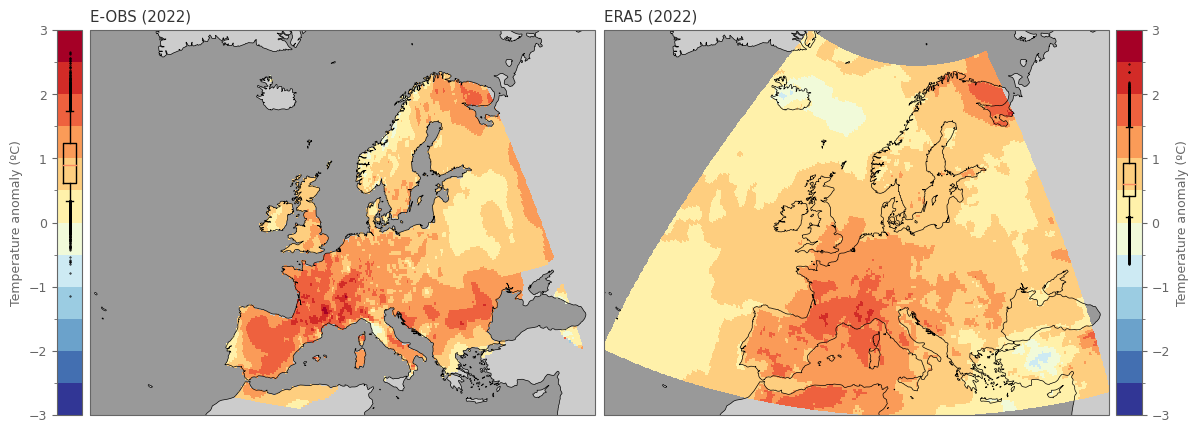

In [27]:
YEAR = 2022

eobs_yearly_anoms.name = "E-OBS"
era5_yearly_anoms.name = "ERA5"

spatial_plot_temperature(eobs_yearly_anoms, era5_yearly_anoms, YEAR)

Et voilà! Here we see the temperature anomaly in 2022 based on ERA5 and E-OBS.

Here too, we calculate the difference. However, we find that although both datasets are represented by a regular 0.25º grid, both grids define the respective center of a grid point differently, resulting in a 0.125 º offset along both latitude and longitude.

In [28]:
era5_yearly_anoms.coords

Coordinates:
  * lon      (lon) float32 -25.0 -24.75 -24.5 -24.25 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float32 34.0 34.25 34.5 34.75 35.0 ... 71.25 71.5 71.75 72.0
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021 2022

In [29]:
eobs_yearly_anoms.coords

Coordinates:
  * lon      (lon) float64 -24.88 -24.62 -24.38 -24.12 ... 39.38 39.62 39.88
  * lat      (lat) float64 34.12 34.38 34.62 34.88 ... 71.12 71.38 71.62 71.88
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021 2022

Fortunately, since they are rectilinear grids, we can use the linear interpolation in `xarray` to interpolate the E-OBS dataset onto the ERA5 grid.

In [30]:
diff = era5_yearly_anoms - eobs_yearly_anoms.interp_like(era5_yearly_anoms)

Now we can also visualize the difference:

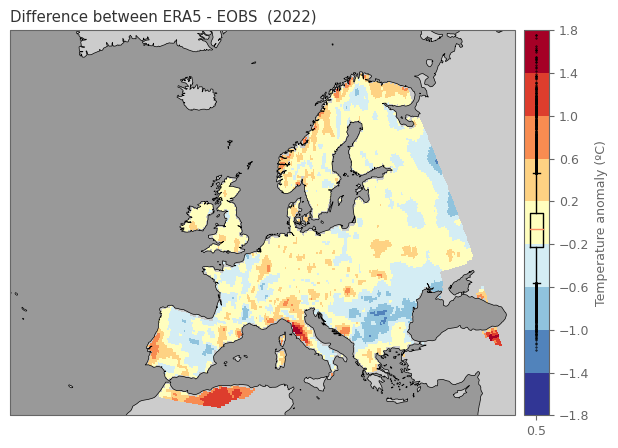

In [31]:
levels = np.arange(-1.8, 1.9, 0.4)
kwargs = dict(
    levels=levels,
    transform=PROJS["Data"],
    cmap="RdYlBu_r",
    cbar_kwargs=dict(label="Temperature anomaly (ºC)"),
)
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 0.05], wspace=0.02)
ax1 = fig.add_subplot(gs[0, 0], projection=PROJS["Europe"])
cax = fig.add_subplot(gs[0, 1])
ax1.coastlines("50m", lw=0.5)
ax1.add_feature(cfeature.OCEAN, facecolor=".6")
ax1.add_feature(cfeature.LAND, facecolor=".8")
ax1.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())
diff.sel(year=YEAR).plot(ax=ax1, cbar_ax=cax, **kwargs)
ax1.set_title(f"Difference between ERA5 - EOBS  ({YEAR})")
dist = diff.sel(year=YEAR).stack(x=("lat", "lon")).dropna("x").values
cax.boxplot(
    dist,
    vert=True,
    positions=[0.5],
    whis=(5, 95),
    widths=0.5,
    flierprops=dict(marker=".", markersize=1),
)
plt.show()


From this plot, the following observations can be made:

- In wide areas of Europe, the difference between ERA5 and E-OBS was less than 0.2ºC.
- The deviations do not show a clear systematic error.
- Larger deviations exist around the rugged coastal areas of Norway, along the coasts of Portugal and Italy, in the Carpathian region, and on the edge of the observation network, such as Algeria and Turkey.

#### Seasonal Anomalies

In this section, we will make similar calculations as in the previous section but for seasonal anomalies instead of annual ones. We start by defining two helper functions that allow us to:

1. Calculate a weighted seasonal mean, taking into account the number of days per month.
2. Convert the time coordinate into seasonal categories.

The calculation of the seasonal mean is basically the same as that of the annual mean. Typically, the boreal seasons are defined as:

- Winter: December, January, February (DJF)
- Spring: March, April, May (MAM)
- Summer: June, July, August (JJA)
- Autumn: September, October, November (SON)

It is important to note that the winter of a year (say 2022) usually consists of December **2021**, January 2022, and February 2022. The following function calculates the weighted seasonal mean:

In [32]:
# Figure 3a. European land surface air temperature anomalies
# for SEASONS, relative to the average for the 1991–2020 reference period.
# -----------------------------------------------------------------------------
def weighted_seasonal_average(ds):
    """Calculate the weighted seasonal average per year and grid point.

    Important: in case there are missing values in the data the weighted average will be wrong.
    """
    month_length = ds.time.dt.days_in_month
    ds_weighted_sum = (ds * month_length).resample(time="QS-DEC").sum(skipna=False)
    sum_of_weights = month_length.resample(time="QS-DEC").sum()
    return ds_weighted_sum / sum_of_weights

Alright, let's walk step by step through the function to understand what's going on there:

**Calculate Month Length** 

`month_length = ds.time.dt.days_in_month` 

calculates the number of days in each month for each time step in the dataset. This will be used as the weights since some months have more days than others.


**Calculate Weighted Sum for Each Season**

`ds_weighted_sum = (ds * month_length).resample(time="QS-DEC").sum(skipna=False)` 

multiplies the dataset by the month lengths, weighting each value by the number of days in that month. Then it's resampled by the quarter starting in December (`"QS-DEC"`), and the sum is calculated for each quarter, resulting in a seasonal sum.

**Calculate Sum of Weights for Each Season**

`sum_of_weights = month_length.resample(time="QS-DEC").sum()` 

calculates the sum of the weights (days in months) for each season. This ensures that the average takes into account the varying number of days in different seasons.


**Calculate the Weighted Seasonal Average**

`return ds_weighted_sum / sum_of_weights` 

divides the weighted sum for each season by the sum of the weights for that season, resulting in a weighted seasonal average.

In [33]:
eobs_seasonal = weighted_seasonal_average(eobs[["anom"]])
era5_seasonal = weighted_seasonal_average(era5[["anom", "lsm"]])
eobs_seasonal.coords

Coordinates:
  * lon      (lon) float64 -24.88 -24.62 -24.38 -24.12 ... 39.38 39.62 39.88
  * lat      (lat) float64 34.12 34.38 34.62 34.88 ... 71.12 71.38 71.62 71.88
  * time     (time) datetime64[ns] 1949-12-01 1950-03-01 ... 2022-12-01

Great! As we can see, the time coordinate is in the `"QS-DEC"` format as expected, i.e., quarterly anchored on December 1st. However, for easier processing and visualization, another coordinate representation is useful, where we replace the `"QS-DEC"` format with two dimensions, `year` and `season`. Ideally, we would like to query our dataset as follows:

`eobs_seasonal.sel(year=2022, season='DJF')`

This is now the second step, the conversion of the `time` coordinate, which is carried out in the following function:

In [34]:
def convert_time_to_year_season(ds):
    """Convert the coordinates of a DataArray from "time" to ("year", "season")"""
    # Get the year and season for each time
    year = ds.time.dt.year
    season = ds.time.dt.season

    # Assign the new coordinates (year, season)
    ds = ds.assign_coords(year=("time", year.data), season=("time", season.data))

    # Set the index of time as a MultiIndex which can then be unstacked into (..., "season", "year")
    return ds.set_index(time=("year", "season")).unstack("time")


Before applying the function, however, we must note that with the current implementation, winter 2022 would be assigned to 2021. A small workaround helps us here by shifting the time axis 31 days forward, so that all corresponding seasons fall into one year.

In [35]:
eobs_seasonal.coords.update({"time": eobs_seasonal.time + pd.Timedelta(days=31)})
era5_seasonal.coords.update({"time": era5_seasonal.time + pd.Timedelta(days=31)})

eobs_seasonal = convert_time_to_year_season(eobs_seasonal)
era5_seasonal = convert_time_to_year_season(era5_seasonal)

eobs_seasonal.loc[dict(season="DJF", year=[1950, 2023])] = np.nan
era5_seasonal.loc[dict(season="DJF", year=[1950, 2023])] = np.nan

In the last two lines, we also replaced the first and last winter with `NaN`, which are not fully represented in the datasets. Finally, we calculate the spatial means over the individual seasons using our previously defined function:

In [36]:
eobs_seasonal_average = weighted_spatial_average(eobs_seasonal["anom"])
era5_seasonal_average = weighted_spatial_average(era5_seasonal["anom"], land_mask=era5_seasonal["lsm"])

For visualization, we can recycle our previous bar plot. Here we plot the time series for summer in Europe:

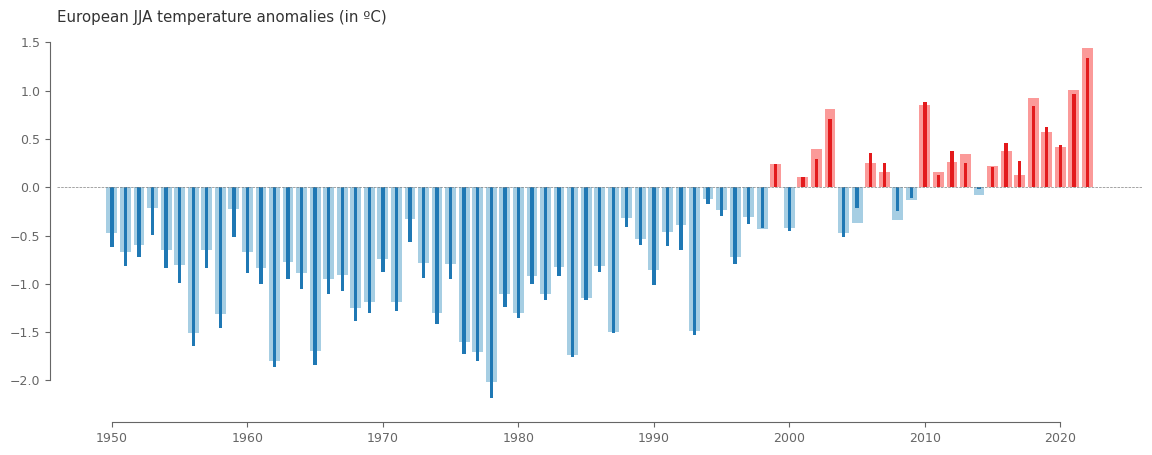

In [37]:
eobs_seasonal_average.name = "E-OBS"
era5_seasonal_average.name = "ERA5"

SEASON = "JJA"

title = f"European {SEASON} temperature anomalies (in ºC)"
barplot_temperature(
    eobs_seasonal_average.sel(season=SEASON, drop=True),
    era5_seasonal_average.sel(season=SEASON, drop=True),
    title,
)


Also, for the spatial distribution of seasonal averages, we rely on our previously defined functions:

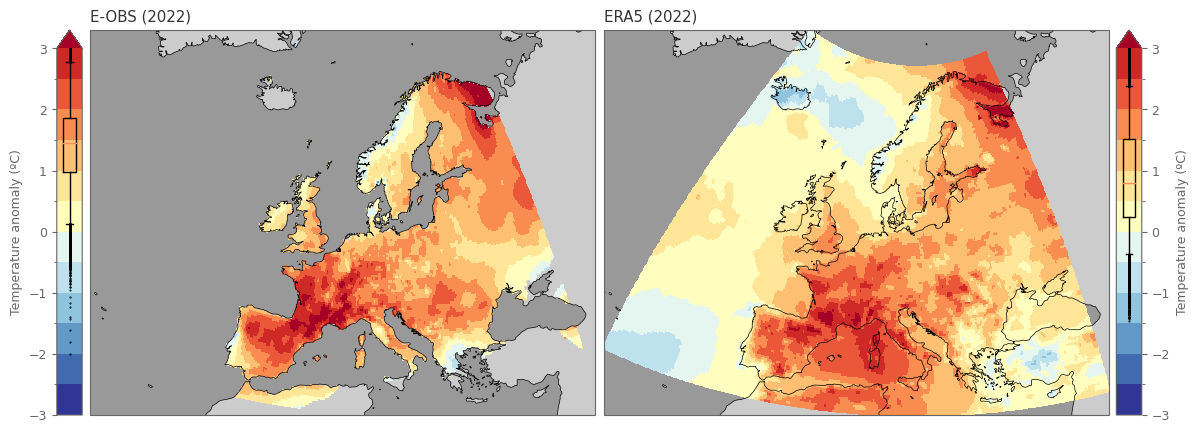

In [38]:
# Figure 4b. Surface air temperature anomalies for winter, spring, summer
# and autumn 2022, relative to the respective seasonal average for the
# 1991–2020 reference period.
# -----------------------------------------------------------------------------
eobs_seasonal_anom = eobs_seasonal["anom"].sel(season=SEASON)
era5_seasonal_anom = era5_seasonal["anom"].sel(season=SEASON)

eobs_seasonal_anom.name = "E-OBS"
era5_seasonal_anom.name = "ERA5"

# change again the levels for the colorbar
levels = np.arange(-3, 3.5, 0.5)
kwargs = dict(
    levels=levels,
    transform=PROJS["Data"],
    cmap="RdYlBu_r",
    cbar_kwargs=dict(label="Temperature anomaly (ºC)"),
)

spatial_plot_temperature(
    eobs_seasonal_anom,
    era5_seasonal_anom,
    YEAR,
)

#### Monthly Anomalies

No further preprocessing is needed for the visualisation of the monthly anomalies, as our data already exist in a monthly resolution, and we calculated the anomalies right at the beginning. So, let's dive straight into the visualisation!

In [39]:
def convert_time_to_year_month(ds):
    """Convert the coordinates of a DataArray from "time" to ("year", "month")"""
    # Get the year and season for each time
    year = ds.time.dt.year
    month = ds.time.dt.month

    # Assign the new coordinates (year, season)
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # Set the index of time as a MultiIndex which can then be unstacked into (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")


In [42]:
# Figure 5. Average surface air temperature anomalies for each month
# of 2022, relative to the respective monthly average for the 1991–2020
# reference period. Data source: ERA5. Credit: C3S/ECMWF.
# -----------------------------------------------------------------------------
def plot_monthly_overview(da, title, **kwargs):
    da = convert_time_to_year_month(da)
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(
        4, 4, figure=fig, wspace=0.02, hspace=0.02, width_ratios=[1, 1, 1, 0.05]
    )
    axes = [
        fig.add_subplot(gs[i // 3, i % 3], projection=PROJS["Europe"])
        for i in range(12)
    ]
    cax = fig.add_subplot(gs[:, 3])

    for ax, month in zip(axes, da.month.values):
        da.sel(month=month).plot(ax=ax, cbar_ax=cax, **kwargs)
        ax.set_title("")
        ax.coastlines("50m", lw=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor=".6")
        ax.add_feature(cfeature.LAND, facecolor=".8")
        ax.text(
            0.02,
            0.98,
            calendar.month_name[month],
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=12,
            bbox=dict(facecolor="w", edgecolor="w", boxstyle="round", alpha=0.8),
        )

    fig.suptitle(title, y=0.91)

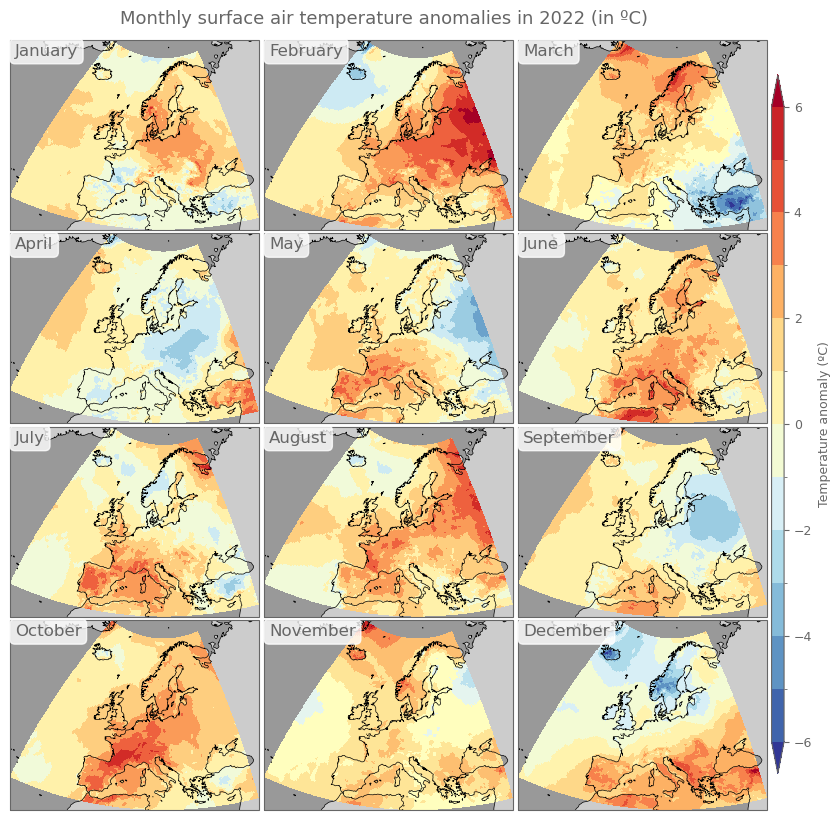

In [43]:
title = "Monthly surface air temperature anomalies in 2022 (in ºC)"
kwargs.update({"levels": np.arange(-6, 6.5, 1.0), "vmin": -6, "vmax": 6})
plot_monthly_overview(era5["anom"].sel(time=str(YEAR)), title, **kwargs)

Analogous to the annual differences, we will also calculate monthly differences here, using linear interpolation.

In [44]:
monthly_diffs = era5["anom"].sel(time=str(YEAR)) - eobs["anom"].sel(
    time=str(YEAR)
).interp_like(era5["anom"])

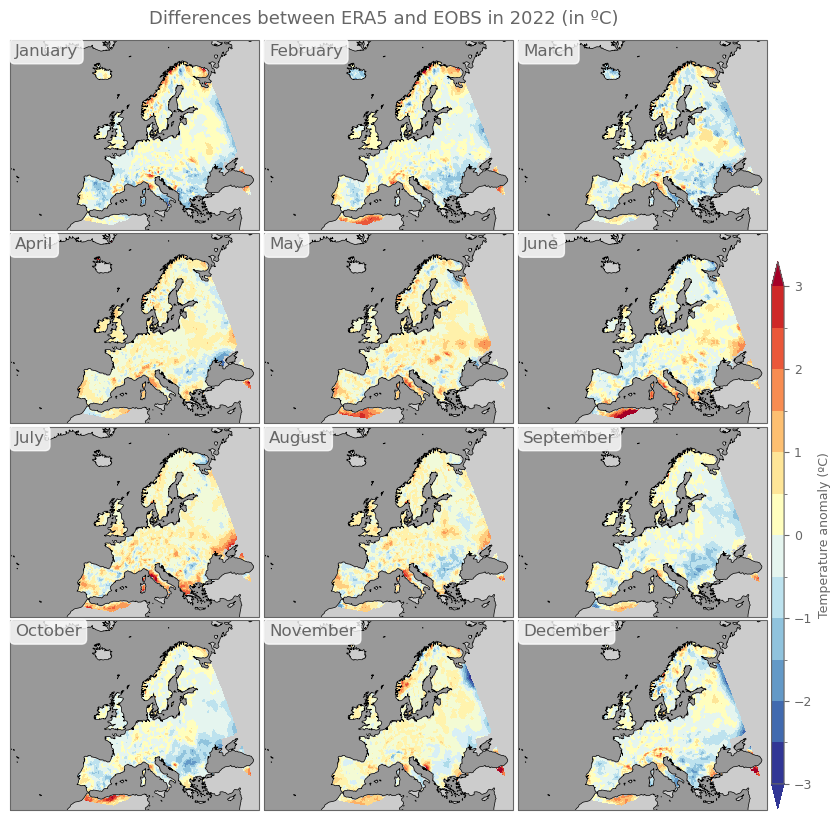

In [45]:
title = "Differences between ERA5 and EOBS in 2022 (in ºC)"
kwargs.update({"levels": np.arange(-3, 3.1, .5), "vmin": -3, "vmax": 3})
plot_monthly_overview(monthly_diffs, title, **kwargs)

#### Daily Anomalies

As our final task, we will compute daily anomalies based on E-OBS. The following section is a direct reproduction of Figure 6 in [ESOTC 2022](https://climate.copernicus.eu/esotc/2022/temperature).

First, we'll calculate daily spatial averages based on the daily temperature values from E-OBS.

In [46]:
eobs_daily_mean = weighted_spatial_average(eobs_daily["tg"])

with ProgressBar():
    eobs_daily_mean = eobs_daily_mean.compute()

[                                        ] | 0% Completed | 103.21 ms

[########################################] | 100% Completed | 32.35 s


Next, we must calculate the daily climatology, meaning the typical temperature for dates such as the 1st of January, the 2nd of January, and so on. These daily climatology values offer a vivid illustration of the expected seasonal temperature trend. However, a closer look reveals that the curve is not as smooth as one might anticipate; it appears rather "noisy." This irregularity stems from the substantial fluctuations that can occur in daily temperatures. For example, the 1st of January in 2019 could be noticeably warmer than the same date in 2020.

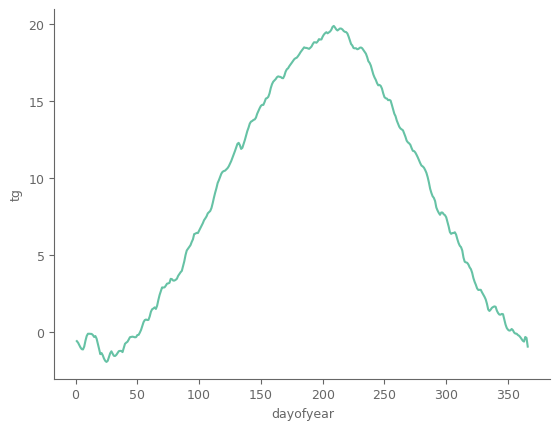

In [47]:
eobs_daily_clim = eobs_daily_mean.sel(REF_PERIOD).groupby("time.dayofyear").mean()
eobs_daily_clim.plot()

To understand these fluctuations, we can examine the 10th and 90th percentiles for each day, classifying temperatures outside this range as "extreme" or "anomalous." From a statistical perspective, pinpointing the extremities of a distribution (such as these percentiles) demands more data than merely calculating an average. Given that the distribution for an individual day might only include 30 values (based on the climatology definition from 1991 to 2020), providing an accurate percentile estimate is challenging.

Climate scientists often circumvent this issue by using a "running window" technique when calculating percentiles. For the 1st of January, for instance, this method would consider all temperature values for that date $\pm (N-1)/2$ days. For example, with $N=31$, the percentiles for the 1st of January would be based on all temperature readings from the 15th of December to the 15th of January across the years 1991 to 2020. In this case, the percentile estimation would be based on $31*30 = 930$ values instead of mere $30$. This window shifts by one day for the subsequent date, facilitating more accurate estimations of daily percentiles. Care must be taken to avoid an excessively large window, as this can lead to the blending of days with distinct climatological characteristics. In the following cell, we will compute these so-called moving percentiles (or quantiles) with a window of N=31, focusing on the 10th, 50th (median), and 90th percentiles.

In [48]:
eobs_windowed = (
    eobs_daily_mean.sel(REF_PERIOD)
    .rolling(time=31, center=True)
    .construct("window_dim")
)
eobs_daily_quantiles = eobs_windowed.groupby("time.dayofyear").quantile(
    [0.1, 0.5, 0.9], dim=["time", "window_dim"]
)
lower, median, upper = eobs_daily_quantiles.sel(dayofyear=slice(1, 365)).transpose(
    "quantile", "dayofyear"
)

Lastly, we need the temperature anomalies for the year 2022 with the same `dayofyear` coordinate as the climatology:

In [49]:
eobs_2022 = eobs_daily_mean.sel(time=str(YEAR)).groupby("time.dayofyear").mean()

Finally, we plot the daily anomaly as positive (red) and negative (blue) deviations from the daily climatology. With the help of the 10th and 90th percentiles, we can identify on which days the year 2022 was "abnormally" warm or cold.

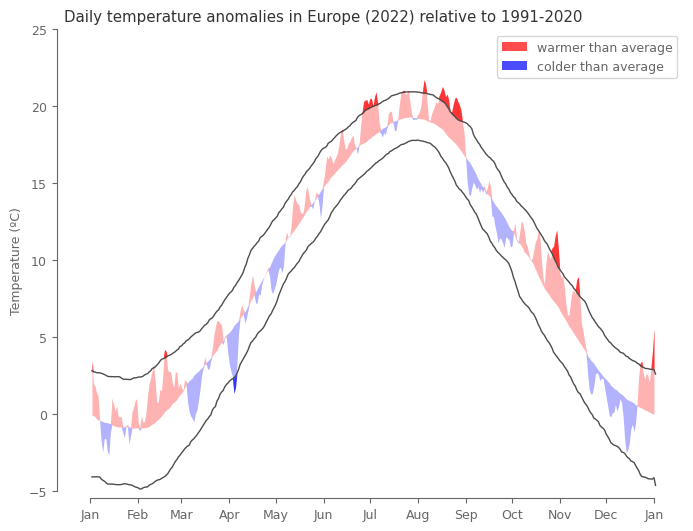

In [50]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
eobs_daily_quantiles.sel(quantile=[0.1, 0.9]).plot.line(
    ax=ax, x="dayofyear", lw=1, color=".3"
)
ax.fill_between(
    median.dayofyear,
    eobs_2022.where(eobs_2022 >= median, median),
    median,
    color="red",
    alpha=0.3,
    lw=0,
    zorder=-1,
)
ax.fill_between(
    median.dayofyear,
    eobs_2022.where(eobs_2022 <= median, median),
    median,
    color="blue",
    alpha=0.3,
    lw=0,
    zorder=-1,
)

ax.fill_between(
    median.dayofyear,
    eobs_2022.where(eobs_2022 >= upper, upper),
    upper,
    color="red",
    alpha=0.7,
    lw=0,
    zorder=1,
    label="warmer than average",
)
ax.fill_between(
    median.dayofyear,
    eobs_2022.where(eobs_2022 <= lower, lower),
    lower,
    color="blue",
    alpha=0.7,
    lw=0,
    zorder=1,
    label="colder than average",
)

days_in_month_2022 = (
    eobs_daily.time.dt.days_in_month.sel(time="2022")
    .resample({"time": "MS"})
    .mean()
)
ax.legend()
xticks = [0] + days_in_month_2022.cumsum().values.tolist()
xticklabels = [calendar.month_abbr[x % 12 + 1] for x in range(len(xticks))]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylim(-5, 25)
ax.set_xlabel("")
ax.set_ylabel("Temperature (ºC)")
ax.set_title("Daily temperature anomalies in Europe (2022) relative to 1991-2020")
sns.despine(ax=ax, offset=5, trim=True)

#### Conclusion

That's it! In this second part, we've taken a closer look at ERA5 by comparing temperature anomalies with observational data in Europe. We have calculated annual, seasonal, monthly, and daily anomalies for this purpose.

In the final part of the trilogy, we will focus on the current temperature anomalies and their visualisation in different regions of our Earth.